# Training Augmented Data

* Creating this notebook to help train a SVM model using augmented data. 
* Attempting this in a separate notebook, because previous attempt took a long time and still didn't converge. 
* This was because we were using `probability=True` along with `GridSearchCV`. This needed additional training to get the probabilities. 
* Our plan is to, 
    * Train a model using `RandomizedGridSearch` without the `probability` to try and get best params for augmented data. 
    * If above doesn't work we'll train the model using the best params from non-augmented dataset. 
    * Finally validate the model against test data to see if we see any performance improvements. 

## Import Libraries

In [2]:
from sklearn.preprocessing import Binarizer, OneHotEncoder, MinMaxScaler, StandardScaler, FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, cross_val_predict,GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import loguniform
from pathlib import Path
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier


from sklearn.metrics import ConfusionMatrixDisplay, f1_score, roc_auc_score, roc_curve, accuracy_score
from sklearn.dummy import DummyClassifier


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import joblib
import json
import gdown

## Read Data

In [3]:
## function to download data from google drive
def download_from_google_drive(file_id, file_name):
    url = f"https://drive.google.com/uc?id={file_id}"
    gdown.download(url, file_name, quiet=False)

In [4]:
## check if mnist data is already downloaded
augmented_train_X_set_path = Path("..", "data", "augmented_train_X.csv")
augmented_train_Y_set_path = Path("..", "data", "augmented_train_Y.csv")
mnist_test_set_path = Path("..", "data", "mnist_test_set.csv")

if not augmented_train_X_set_path.exists():
    ## download train set
    file_id = "10TExQfMfM-ku45L9F1LFU4LxobPM7OrR"
    download_from_google_drive(file_id, str(augmented_train_X_set_path))
    
if not augmented_train_Y_set_path.exists():
    ## download train set
    file_id = "10SL3pSwsyiws9_t6upD3CwilrdtJU6Pg"
    download_from_google_drive(file_id, str(augmented_train_Y_set_path))

if not mnist_test_set_path.exists():
    ## download test set
    file_id = "10Rxuec9x2VxAr6syy4S_yD7hJ5FkyYvP"
    download_from_google_drive(file_id, str(mnist_test_set_path))

### Access Train/Test Data

In [5]:
## access train data
augmented_train_X = pd.read_csv(augmented_train_X_set_path)
augmented_train_Y = pd.read_csv(augmented_train_Y_set_path)

## access test data
mnist_test_set = pd.read_csv(mnist_test_set_path)

In [6]:
augmented_train_X.head()

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
augmented_train_X.shape

(280000, 784)

In [8]:
augmented_train_Y.shape

(280000, 1)

In [9]:
augmented_train_Y.head()

,0
0,0
1,0
2,0
3,0
4,0


## Randomized GridSearchCV

In [10]:
print("Intializing SVC...")
svc = SVC(random_state=42) 

# create pipeline

print("Creating pipeline...")
svc_pipeline = Pipeline([
    ("scaler", MinMaxScaler()),
    ("svc", svc)
], verbose=True)


## randomized grid search params
param_distributions = {
    'svc__C': loguniform(10, 1000),
    'svc__gamma': loguniform(1e-4, 1e1),
    'svc__kernel': ['rbf', 'poly']
}

random_search = RandomizedSearchCV(svc_pipeline, param_distributions, n_iter=10, cv=3, scoring="f1_weighted", n_jobs=-1, verbose=1)


Intializing SVC...
Creating pipeline...


In [11]:
# random_search.fit(augmented_train_X, augmented_train_Y)

* So it looks like training doesn't convert for 3+ hours, so will drop it for now and just try and train the model on best params

## Training Using Best Params

In [12]:
print("Intializing SVC...")
# Best Parameters: {'svc__C': 10, 'svc__gamma': 'scale', 'svc__kernel': 'rbf'}
svc = SVC(C=10, gamma="scale", kernel="rbf", random_state=42)

# create pipeline

print("Creating pipeline...")
svc_pipeline = Pipeline([
    ("scaler", MinMaxScaler()),
    ("svc", svc)
], verbose=True)

Intializing SVC...
Creating pipeline...


In [13]:
svc_pipeline.fit(augmented_train_X, augmented_train_Y.values.ravel())

[Pipeline] ............ (step 1 of 2) Processing scaler, total=   1.8s
[Pipeline] ............... (step 2 of 2) Processing svc, total=78.6min


Pipeline(steps=[('scaler', MinMaxScaler()),
                ('svc', SVC(C=10, random_state=42))],
         verbose=True)

* So it took ~80 mins to converge but we were finally able to train the model
* Lets verify this on test data and see

In [32]:
## save model
joblib.dump(svc_pipeline, Path("..", "models", "svc_augmented_data_v1.joblib"))

['../models/svc_augmented_data_v1.joblib']

In [14]:
## split test features and target into separate dataset
test_X = mnist_test_set.drop("class", axis=1)
test_Y = mnist_test_set["class"]

In [19]:
predictions = svc_pipeline.predict(test_X)

In [22]:
predictions

array([7, 3, 1, ..., 6, 2, 8])

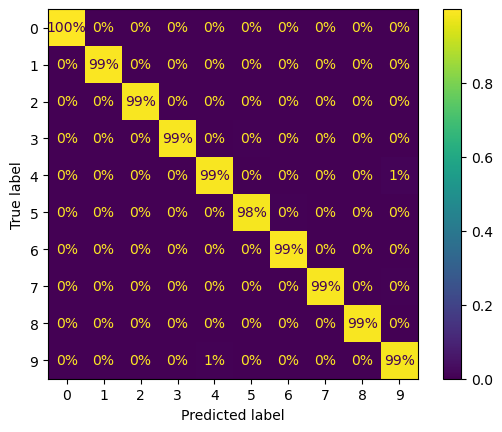

In [23]:
## lets check confusion matrix
ConfusionMatrixDisplay.from_predictions(test_Y, predictions, normalize="true", values_format=".0%")

Observations
* From the confusion matrix, it looks like model is a lot better at predictions than previous models. 
* But to confirm that we'll need to look at other metrics, without probabilities we won't be able to calculate roc score, but we can look at other metrics to make a more educated decision

In [24]:
# Compute metrics
accuracy = accuracy_score(test_Y, predictions)
weighted_f1 = f1_score(test_Y, predictions, average='weighted')
# Compute per-class F1 scores
per_class_f1_scores = f1_score(test_Y, predictions, average=None)
per_class_f1_dict = {f"Class_{i}": score for i, score in enumerate(per_class_f1_scores)}

In [25]:
## print the metrics
print(f"Accuracy: {accuracy}")
print(f"Weighted F1: {weighted_f1}")
print(f"Per-class F1: {per_class_f1_dict}")



Accuracy: 0.9897142857142858
Weighted F1: 0.9897128878139033
Per-class F1: {'Class_0': 0.9953085528690003, 'Class_1': 0.993015873015873, 'Class_2': 0.9881847475832438, 'Class_3': 0.9898209898209899, 'Class_4': 0.9882697947214076, 'Class_5': 0.9876935291782454, 'Class_6': 0.9909321726514327, 'Class_7': 0.988009592326139, 'Class_8': 0.9911958914159942, 'Class_9': 0.9842180774748924}


Observations:
* So the improvement in `Accuracy` and `Weighted F1` is not significant, best score in non augmented data was `0.981679` and with augmented data its `0.98971`. But per-class F1 scores show a lot of improvements. 
* Lets update the metrics csv and create some visualizations to get better idea. 



In [39]:
## read `mnist_models_metrics.csv` file from models folder
models_metrics_path = Path("..", "models", "mnist_models_metrics.csv")
models_metrics = pd.read_csv(models_metrics_path)
models_metrics

,Algorithm,Method,File Name,Accuracy,Weighted F1 Score,ROC AUC Score,Class_0,Class_1,Class_2,Class_3,Class_4,Class_5,Class_6,Class_7,Class_8,Class_9
0,Logistic Regression V0,Default Estimator,logistic_regression_v0.joblib,0.919839,0.919697,0.992891,0.960940,0.964241,0.904483,0.898339,0.926959,0.879824,0.944259,0.929785,0.880834,0.897883
1,Logistic Regression V1,GridSearchCV,logistic_regression_v1.joblib,0.920589,0.920444,0.992934,0.960701,0.964468,0.905045,0.899217,0.927801,0.881860,0.944334,0.930612,0.882478,0.898686
2,Logistic Regression V2,GridSearchCV,logistic_regression_v2.joblib,0.921375,0.921193,0.993371,0.961961,0.960945,0.908795,0.900696,0.927737,0.880727,0.948119,0.931754,0.884302,0.898043
3,SVC V0,Default Estimator,svc_v0.joblib,0.975714,0.975704,0.999430,0.986884,0.987332,0.973360,0.969809,0.974799,0.972035,0.984920,0.973797,0.967949,0.964572
4,SVC V1,GridSearchCV,svc_v1.joblib,0.975714,0.975704,0.999430,0.986884,0.987332,0.973360,0.969809,0.974799,0.972035,0.984920,0.973797,0.967949,0.964572
5,SVC V2,GridSearchCV,svc_v2.joblib,0.981679,0.981675,0.999645,0.988693,0.991675,0.979559,0.977715,0.980715,0.978297,0.987825,0.980365,0.976169,0.974281
6,SVC V3,RandomSearchCV,svc_v3.joblib,0.981607,0.981603,0.999644,0.988693,0.991754,0.979464,0.977454,0.980715,0.978196,0.987735,0.980456,0.976084,0.974004
7,Random Forest V0,Default Estimator,random_forest_v0.joblib,0.965125,0.965098,0.998773,0.981769,0.983666,0.960192,0.953010,0.966229,0.961390,0.978281,0.966644,0.950865,0.946440
8,Random Forest V1,GridSearchCV,random_forest_v1.joblib,0.966893,0.966873,0.998921,0.982212,0.985167,0.962174,0.955628,0.968573,0.963796,0.979182,0.968957,0.952678,0.947908
9,KNN V0,Default Estimator,knn_v0.joblib,0.967804,0.967736,0.994503,0.983839,0.973455,0.970026,0.962827,0.970087,0.960794,0.983458,0.964289,0.953814,0.953750


In [40]:
models_metrics.columns

Index(['Algorithm', 'Method', 'File Name', 'Accuracy', 'Weighted F1 Score',
       'ROC AUC Score', 'Class_0', 'Class_1', 'Class_2', 'Class_3', 'Class_4',
       'Class_5', 'Class_6', 'Class_7', 'Class_8', 'Class_9'],
      dtype='object')

In [ ]:
## update the model_metrics dataframe with the new metrics
new_metrics = {
   "Algorithm": "SVC V4",
    "Method": "Best Parameters",
    "File Name": "svc_augmented_data_v1.joblib",
    "Accuracy": accuracy,
    "Weighted F1 Score": weighted_f1,
    "ROC AUC Score": "n/a",
    **per_class_f1_dict
}

# models_metrics = models_metrics.append(new_metrics, ignore_index=True)


In [43]:
models_metrics = pd.concat([models_metrics, pd.DataFrame([new_metrics])], ignore_index=True)

In [44]:
models_metrics

,Algorithm,Method,File Name,Accuracy,Weighted F1 Score,ROC AUC Score,Class_0,Class_1,Class_2,Class_3,Class_4,Class_5,Class_6,Class_7,Class_8,Class_9
0,Logistic Regression V0,Default Estimator,logistic_regression_v0.joblib,0.919839,0.919697,0.992891,0.960940,0.964241,0.904483,0.898339,0.926959,0.879824,0.944259,0.929785,0.880834,0.897883
1,Logistic Regression V1,GridSearchCV,logistic_regression_v1.joblib,0.920589,0.920444,0.992934,0.960701,0.964468,0.905045,0.899217,0.927801,0.881860,0.944334,0.930612,0.882478,0.898686
2,Logistic Regression V2,GridSearchCV,logistic_regression_v2.joblib,0.921375,0.921193,0.993371,0.961961,0.960945,0.908795,0.900696,0.927737,0.880727,0.948119,0.931754,0.884302,0.898043
3,SVC V0,Default Estimator,svc_v0.joblib,0.975714,0.975704,0.99943,0.986884,0.987332,0.973360,0.969809,0.974799,0.972035,0.984920,0.973797,0.967949,0.964572
4,SVC V1,GridSearchCV,svc_v1.joblib,0.975714,0.975704,0.99943,0.986884,0.987332,0.973360,0.969809,0.974799,0.972035,0.984920,0.973797,0.967949,0.964572
5,SVC V2,GridSearchCV,svc_v2.joblib,0.981679,0.981675,0.999645,0.988693,0.991675,0.979559,0.977715,0.980715,0.978297,0.987825,0.980365,0.976169,0.974281
6,SVC V3,RandomSearchCV,svc_v3.joblib,0.981607,0.981603,0.999644,0.988693,0.991754,0.979464,0.977454,0.980715,0.978196,0.987735,0.980456,0.976084,0.974004
7,Random Forest V0,Default Estimator,random_forest_v0.joblib,0.965125,0.965098,0.998773,0.981769,0.983666,0.960192,0.953010,0.966229,0.961390,0.978281,0.966644,0.950865,0.946440
8,Random Forest V1,GridSearchCV,random_forest_v1.joblib,0.966893,0.966873,0.998921,0.982212,0.985167,0.962174,0.955628,0.968573,0.963796,0.979182,0.968957,0.952678,0.947908
9,KNN V0,Default Estimator,knn_v0.joblib,0.967804,0.967736,0.994503,0.983839,0.973455,0.970026,0.962827,0.970087,0.960794,0.983458,0.964289,0.953814,0.953750


In [58]:
## lets create a horizontal bar chart for the weighted f1 score, accuracy and per class f1 scores
## we will use plotly express for this
fig = px.bar(models_metrics.sort_values(by="Weighted F1 Score", ascending=False), x='Algorithm', y='Weighted F1 Score', title='Weighted F1 Score of different models', color='Algorithm')
## save the figure
fig.write_image(Path("..", "visualization", "weighted_f1_score_comparison.png"))
fig.show()

In [59]:
fig = px.bar(models_metrics.sort_values(by="Accuracy", ascending=False), x='Algorithm', y='Accuracy', title='Weighted F1 Score of different models', color='Algorithm')
fig.write_image(Path("..", "visualization", "accuracy_comparison.png"))
fig.show()

In [60]:
## Lets draw line chart for per class f1 scores, with class as x-axis and f1 score as y-axis and different lines for different models
for class_i in range(10):
    fig = px.bar(models_metrics.sort_values(by=f"Class_{class_i}", ascending=False), x='Algorithm', y=f"Class_{class_i}", title=f'Per Class F1 Score of different models for Class {class_i}',
                  color='Algorithm')
    fig.write_image(Path("..", "visualization", f"class_{class_i}_f1_score.png"))

    fig.show()

Observations:
* As expected the augmented data model slightly outperforms all the other models. 


In [57]:
## save models_metrics dataframe to csv
models_metrics.to_csv(models_metrics_path, index=False)